In [1]:
import imp
import hydra.experimental
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
tf.enable_eager_execution()

import precog.esp_train as esp_train
import precog.utils.rand_util as randu
import precog.plotting.plot as plot

# import precog.dataset.trimodal_dataset as tri_dataset
# import precog.dataset.serialized_dataset as dill_dataset
# import precog.utils.tfutil as tfu
# import precog.utils.similarity_util as similarityu
%matplotlib inline

hydra.experimental.initialize(config_dir="../precog/conf/", strict=True)
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

/home/nrhinehart/pre3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/nrhinehart/pre3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/nrhinehart/pre3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/nrhinehart/pre3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.

In [2]:
rand_dir = randu.random_string(5)

os.mkdir(rand_dir)
os.chdir(rand_dir)

cfg=hydra.experimental.compose('esp_train_config.yaml', overrides=['dataset=nuscenes_dataset', 'bijection.params.A=5'])
# cfg=hydra.experimental.compose('dataset/nuscenes_dataset.yaml', overrides=[cfg])

In [3]:
cfg.main.eager = True
opt=esp_train.prepare_for_optimization(cfg)

minibatch = opt.dataset.get_minibatch_with_replacement(is_training=True)
obj_return = opt.objective(opt.model_distribution, None, opt.data_distribution_proxy, minibatch) 
expert_rollout = obj_return.rollout

Starting main. argv: /home/nrhinehart/pre3/lib/python3.6/site-packages/ipykernel_launcher.py -f /home/nrhinehart/.local/share/jupyter/runtime/kernel-610505e4-68b1-4ca7-8b1a-2b2f3aeb3dea.json
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
[<Cell A1 ''>, <Cell B1 ''>, <Cell C1 ''>, <Cell D1 ''>, <Cell E1 ''>, <Cell F1 ''>, <Cell G1 ''>, <Cell H1 ''>, <Cell I1 ''>, <Cell J1 ''>, <Cell K1 ''>, <Cell L1 ''>, <Cell M1 ''>, <Cell N1 ''>, <Cell O1 ''>, <Cell P1 ''>, <Cell Q1 ''>, <Cell R1 ''>, <Cell S1 ''>, <Cell T1 ''>, <Cell U1 ''>, <Cell V1 ''>, <Cell W1

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



In [4]:
np.set_printoptions(precision=2)

a=1
t=1
print("Local2Grid\n=======\n")
print("R_0^{}\n===\n".format(a), expert_rollout.phi.local2grid.R[0,a].numpy())
print("\nt_0^{}\n===\n".format(a), expert_rollout.phi.local2grid.t[0,a])

print("\nR_{}^{}\n===\n".format(t, a), expert_rollout.metadata_list[t]['local2grid'].R[0,0,a])
print("\nR_{}^{}\n===\n".format(t, a), expert_rollout.metadata_list[t]['local2grid'].t[0,0,a])

Local2Grid

R_0^1
===
 [[ 1.  0.]
 [-0.  1.]]

t_0^1
===
 tf.Tensor([53.32 54.76], shape=(2,), dtype=float64)

R_1^1
===
 tf.Tensor(
[[ 1.  0.]
 [-0.  1.]], shape=(2, 2), dtype=float64)

R_1^1
===
 tf.Tensor([53.35 54.74], shape=(2,), dtype=float64)


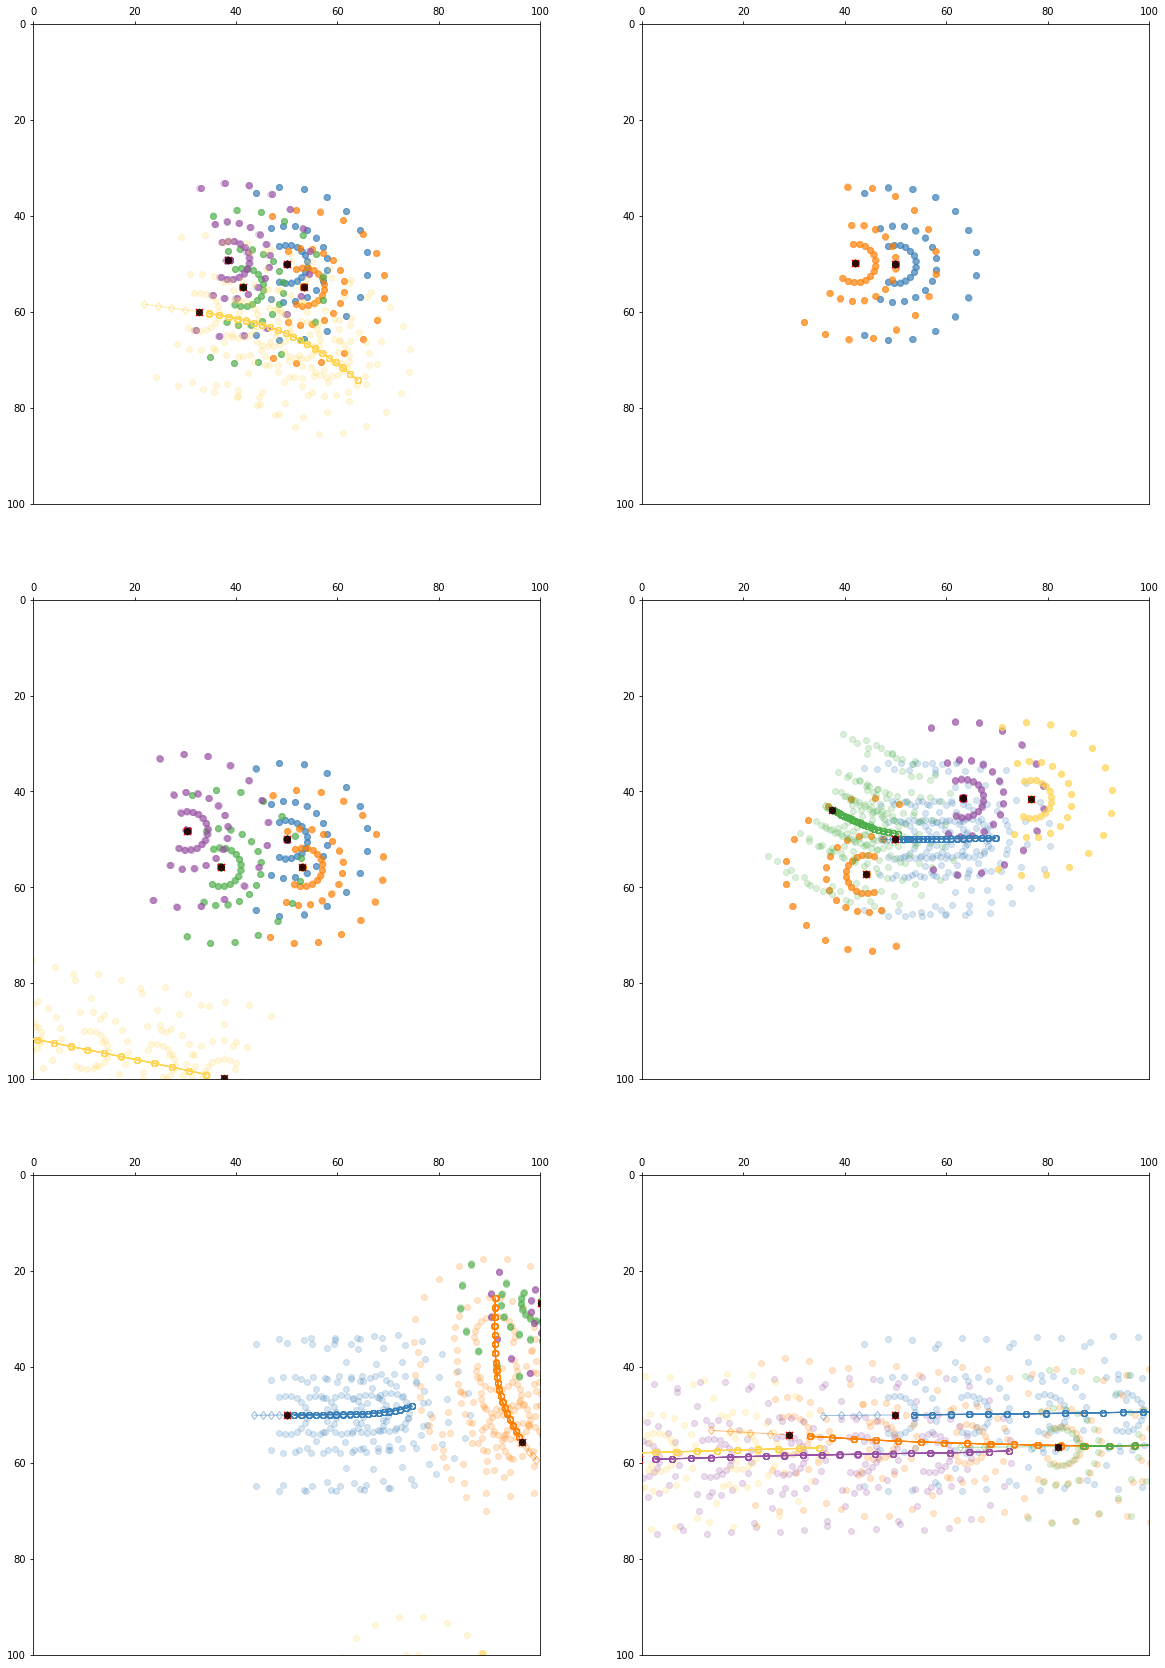

In [5]:
fig, axes = plot.get_figure(nrows=3,ncols=2,figsize=(20,30))
plotwhisk = False
a = 1
k = 0
for b in range(min(10, axes.ravel().size)):
    ax = axes.ravel()[b]
    _=plot.plot_past(expert_rollout.phi.S_past_grid_frame, b=b, fig=fig, ax=axes.ravel()[b], limit=100)
    _=plot.plot_rollout(expert_rollout, fig=fig, ax=axes.ravel()[b], b=b)
    ax.scatter(*expert_rollout.phi.original_local2grid.t[b,0].numpy().T, color='red', marker='x', s=50,zorder=1000)
    for a in range(5):
        for t in range(0,18,4):
            w = expert_rollout.metadata_list[t]['whiskers_grid'][b,k,a].numpy()
            wx,wy=w[:,0],w[:,1]
            ax.scatter(wx,wy,alpha=0.2,color=plot.COLORS[a])
#     ax.annotate("last", (wx[wx.size//2],wy[wx.size//2]))
    points_l2w = expert_rollout.metadata_list[0]['local2grid'].t[b,k]
    axes.ravel()[b].scatter(points_l2w[:,0],points_l2w[:,1],alpha=0.8,color='k', zorder=1000, s=40)
    ax.xaxis.tick_top()
